# 02 - Kernel methods and SVMs
** Ecole Centrale Nantes **

** Diana Mateus **





PARTICIPANTS: Meryam ASSERMOUH - Ikrame HAD
    

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage import io
import random


from skimage.color import rgb2gray
from skimage.transform import resize

from sklearn.svm import SVC
from sklearn.utils import shuffle


# 1. Image classification on Caltech 101

**a)** Download images from
http://www.vision.caltech.edu/feifeili/Datasets.htm
and run the code bellow to check the files and store the name of the classes in the list ```labelNamesAll```

(Just run)

In [2]:
## VERIFY LOCATION AND STORE LABEL NAMES

IMDIR = '101_ObjectCategories'
#IMDIR = '101_ObjectCategories.tar.gz/101_ObjectCategories.tar/101_ObjectCategories'


labelNamesAll = []

for root, dirnames, filenames in os.walk(IMDIR):
    labelNamesAll.append(dirnames)
    #uncomment to check what is found in this folder
    for filename in filenames:
        f = os.path.join(root, filename)
        #if f.endswith(('.png', '.jpg', '.jpeg','.JPG', '.tif', '.gif')):
            #print(f)

labelNamesAll = labelNamesAll[0]

#The list of all labels/directories is
print(labelNamesAll)

['accordion', 'airplanes', 'anchor', 'ant', 'BACKGROUND_Google', 'barrel', 'bass', 'beaver', 'binocular', 'bonsai', 'brain', 'brontosaurus', 'buddha', 'butterfly', 'camera', 'cannon', 'car_side', 'ceiling_fan', 'cellphone', 'chair', 'chandelier', 'cougar_body', 'cougar_face', 'crab', 'crayfish', 'crocodile', 'crocodile_head', 'cup', 'dalmatian', 'dollar_bill', 'dolphin', 'dragonfly', 'electric_guitar', 'elephant', 'emu', 'euphonium', 'ewer', 'Faces', 'Faces_easy', 'ferry', 'flamingo', 'flamingo_head', 'garfield', 'gerenuk', 'gramophone', 'grand_piano', 'hawksbill', 'headphone', 'hedgehog', 'helicopter', 'ibis', 'inline_skate', 'joshua_tree', 'kangaroo', 'ketch', 'lamp', 'laptop', 'Leopards', 'llama', 'lobster', 'lotus', 'mandolin', 'mayfly', 'menorah', 'metronome', 'minaret', 'Motorbikes', 'nautilus', 'octopus', 'okapi', 'pagoda', 'panda', 'pigeon', 'pizza', 'platypus', 'pyramid', 'revolver', 'rhino', 'rooster', 'saxophone', 'schooner', 'scissors', 'scorpion', 'sea_horse', 'snoopy', 's

**b. Build a reduced dataset for accelerating process.** To do so: 
- Consider only up to $K$ randomly drawn categories (start with a binary case)
- Read only up to $N$ images for each class
- Resize the images to $(imWidth*imHeight)$

The dataset should consist of a 
- Input matrix $\mathbf{X}$ of size $(K\cdot N)\times (imWidth\cdot imHeight)$ with one image in every row of the matrix. 
- Output vector $\mathbf{y}$ of size $(K\cdot N)\times 1$ with the label index of each input point in $\bf X$.
- the reduced list of the label names of size $K$ to map between the indices and the names.

**Note than different classes may have different number of images so that the actual number of $\bf X$ and $\bf y$ is less than $K*N$**

(Run and try to understand the structure of the data)

In [3]:
#build DATASET from K categories and (up to) N images from category
K = 2 
N = 40
imWidth = 100 #resize images
imHeight = 100

#selection of label indices
X = np.zeros([K*N,imHeight*imWidth]) #data matrix, one image per row
#Y = np.zeros([K*N,1]) #label indices
Y = -np.ones([K*N,1]) #label indices
labelNames = []

random.seed(a=42) #uncomment to make errors reproducible/comment to see variability

globalCount = 0
for i in range(K): 
    while True:
        lab = random.randint(0,len(labelNamesAll)-1)
        if lab not in labelNames:
            break
    #folders are named after the class label
    filedir = os.path.join(IMDIR,labelNamesAll[lab])
    print(filedir)

    #save the name of the class
    labelNames.append(labelNamesAll[lab])       

    classCount = 0
    for filename in os.listdir(filedir):
        f = os.path.join(filedir, filename)
        if f.endswith(('.jpg')) and (classCount < N):
            #image = skimage.io.imread(f, as_grey=True) #Try this line instead of the one below if there is an error
            image = skimage.io.imread(f, as_gray=True)
            image = skimage.transform.resize(image, [imHeight,imWidth],mode='constant')#,anti_aliasing=True)
            X[globalCount,:] = image.flatten()
            Y[globalCount,:] = i
            globalCount += 1
            classCount += 1

#Remove the unused entries of X and Y
print("Total number of samples",globalCount)
X = X[:globalCount,:]
Y = Y[:globalCount,:]

#Check the stored classes
print("used labels",labelNames)
print("Size of data matrix", X.shape)
print("clas labels", Y.T)



101_ObjectCategories\scissors
101_ObjectCategories\camera
Total number of samples 79
used labels ['scissors', 'camera']
Size of data matrix (79, 10000)
clas labels [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1.]]


**c**. Split the dataset into train (80% of samples) and test (20% samples). 
(Run and try to understand the structure of the data)

In [4]:
# Split in Train and test set with 80% - 20% rule

Ntrain = np.rint(.8*Y.shape[0]).astype(int)
Ntest = Y.shape[0]-Ntrain
print('Training with', Ntrain , 'training samples and ', Ntest, 'testing samples.')

# Randomize the order of X and Y
X, Y = shuffle(X, Y, random_state=0)


# Split the data and labels into training/testing sets
X_train = X[0:Ntrain,:]
Y_train = Y[0:Ntrain,:]

X_test = X[Ntrain:,:]
Y_test = Y[Ntrain:,:]

print("size of train dataset",X_train.shape)
print("size of test dataset",X_test.shape)
print("train target vector",Y_train.T)
print("test target vector",Y_test.T)

Training with 63 training samples and  16 testing samples.
size of train dataset (63, 10000)
size of test dataset (16, 10000)
train target vector [[1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1.
  1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0.
  0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0.]]
test target vector [[0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1.]]


**d) Training and testing a SVM
- Create an SVC model using the sklearn module, 
- train it on the train set, 
- and test it on the test set**. 

(Fill in the code and answer the questions)

**Question** SVMs are intrinsically binary classifiers, can you train the SVC for K>2? How is that achieved?

**ANSWER**: Fill your answer here

In [5]:
# Create, train and test an svm model using the sklearn SVC


# FILL YOUR CODE HERE 
svc = SVC()
svc.fit(X_train,Y_train)
Y_pred=svc.predict(X_test)
score= svc.score(X_train, Y_train)


print("True classes",Y_test.T)
print("Predictions",Y_pred)
errors = np.sum((Y_test.ravel()!=Y_pred))
print('There were ', errors, 'errors')
print("score=",score)

True classes [[0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1.]]
Predictions [0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1.]
There were  1 errors
score= 1.0


C:\Users\Meryam\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


**e) Fill in the functions bellow to computing different evaluation measures and give a performance report**
Look at the formulas and definitions in https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)

Start by computing the confusion matrix, and the values TP, TN, FP, FN, for a binary case. When considering multiple clases ($K>2$) treat one class at a time as the postive class, and the remaining classes as negative. You may want to indicate the positive class as a parameter to the indicator function.

**Question:** There are three ways of resuming the scores for a multiple class problem $K>2$, namely, the macroaverage, the microaverage and the weighted average. Implement and EXPLAIN them below.

**Hint** Add a numerical zero eps to the denominators to prevent dividing by zero

**Hint2** for the multi-class case:

https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin.

**ANSWER** Write your answer in the report

In [6]:
# Functions to compute the errors between prediction and ground truth 

def compute_measures(Y_gt,Y_pred, positiveClass=1): #Y_gt = ground truth
    measures = dict()
    Y_len = len(Y_gt)
    
    eps = 1e-12
    
    #T-class - positiveClass - Y_pred
    #F-class - other - Y_pred
    #P-class - positiveClass - Y_gt
    #N-class - other - Y_gt
    
    #calculat the number of iterations of 0 and 1
    T = P = F = N = 0
    for i in range(len(Y_pred)): (T,F)=(T+1,F) if Y_pred[i]==positiveClass else (T,F+1)
    for i in range(len(Y_gt)): (P,N)=(P+1,N) if Y_gt[i]==positiveClass else (P,N+1)
    
    TP = TN = FP = FN = 0
    for i in range( len(Y_pred) ):
        if Y_pred[i]== Y_gt[i] == positiveClass:
            TP += 1
        elif Y_pred[i]!=Y_gt[i] and  Y_gt[i] == positiveClass:
            FN += 1
        elif Y_pred[i]!=positiveClass and  Y_gt[i] != positiveClass:
            TN += 1
        else:
            FP += 1
            
        
    # True positives TP
    TP = TP
        
    # True negatives TN
    TN = TN
    
    # False positives FP
    FP = FP
        
    # False negatives FN
    FN = FN

    print('TP ', TP, 'TN ', TN, 'FP', FP, 'FN', FN, 'Total', TP+TN+FP+FN)
    measures['TP'] = TP
    measures['TN'] = TN
    measures['FP'] = FP
    measures['FN'] = FN
    
    
    # Accuracy
    measures['accuracy'] = float(TP+TN)/max(P+N,eps)
    
    # Precision
    measures['precision'] = float(TP)/max(TP+FP,eps)
        
    # Specificity
    measures['specificity']=float(TN)/max(N,eps)
    
    # Recall
    measures['recall'] = float(TP)/max(P,eps)
    
    # F-measure
    measures['f1'] = 2*float(TP)/max(2*TP+FP+FN,eps)
    
    # Negative Predictive Value
    measures['npv'] = float(TN)/max(TN+FN,eps)
    
    # False Predictive Value
    measures['fpr'] = float(FP)/max(N,eps)
    
    print('Accuracy ', measures['accuracy'], '\n',
          'Precision', measures['precision'], '\n',
          'Recall', measures['recall'], '\n',
          'Specificity ', measures['specificity'], '\n',
          'F-measure', measures['f1'], '\n',
          'NPV', measures['npv'],'\n',
          'FPV', measures['fpr'],'\n')


    return measures



def micro_average(measuresList):
    microAverage = dict()
    eps = 1e-12
    
    microTP = 0.0;
    microTN = 0.0;
    microFP = 0.0;
    microFN = 0.0;
    for i in range(len(measuresList)):
        microTP += measuresList[i]["TP"];
        microTN += measuresList[i]["TN"];
        microFP += measuresList[i]["FP"];
        microFN += measuresList[i]["FN"];
        
    somme = microTP+microTN+microFP+microFN
    
    # Accuracy
    microAverage['accuracy'] = (microTP+microTN)/max(somme,eps)
    
    # Precision
    microAverage['precision'] = microTP/max(microTP+microFP,eps)
        
    # Specificity
    microAverage['specificity'] = microTN/max(microTN+microFP,eps)
    
    # Recall
    microAverage['recall'] = microTP/max(microTP+microFN,eps)
    
    # F-measure
    microAverage['f1'] = 2*microTP/max(2*microTP+microFP+microFN,eps)
    
    # Negative Predictive Value
    microAverage['npv'] = microTN/max(microTN+microFN,eps)
    
    # False Predictive Value
    microAverage['fpr'] = microFP/max(microFP+microTN,eps)
    
        
    print('Accuracy ', microAverage['accuracy'], '\n',
          'Precision', microAverage['precision'], '\n',
          'Recall', microAverage['recall'], '\n',
          'Specificity ', microAverage['specificity'], '\n',
          'F-measure', microAverage['f1'], '\n',
          'NPV', microAverage['npv'],'\n',
          'FPV', microAverage['fpr'],'\n')
    
    return microAverage



def macro_average(measuresList):
    macroAverage = dict()
    
    n = len(measuresList)
    macroAverage['accuracy']    = 0.0
    macroAverage['precision']   = 0.0
    macroAverage['specificity'] = 0.0
    macroAverage['recall']      = 0.0
    macroAverage['f1']          = 0.0
    macroAverage['npv']         = 0.0
    macroAverage['fpr']         = 0.0
    
    for i in range(n):
        macroAverage['accuracy']    +=measuresList[i]['accuracy']
        macroAverage['precision']   +=measuresList[i]['precision']
        macroAverage['specificity'] +=measuresList[i]['specificity']
        macroAverage['recall']      +=measuresList[i]['recall']
        macroAverage['f1']          +=measuresList[i]['f1']
        macroAverage['npv']         +=measuresList[i]['npv']
        macroAverage['fpr']         +=measuresList[i]['fpr']
    
    
    # Accuracy
    macroAverage['accuracy'] /= n
    
    # Precision
    macroAverage['precision'] /= n 
        
    # Specificity
    macroAverage['specificity'] /= n
    
    # Recall
    macroAverage['recall'] /=n 
    
    # F-measure
    macroAverage['f1'] /= n 
    
    # Negative Predictive Value
    macroAverage['npv'] /= n
    
    # False Predictive Value
    macroAverage['fpr'] /= n
    
    print('Accuracy ', macroAverage['accuracy'], '\n',
          'Precision', macroAverage['precision'], '\n',
          'Recall', macroAverage['recall'], '\n',
          'Specificity ', macroAverage['specificity'], '\n',
          'F-measure', macroAverage['f1'], '\n',
          'NPV', macroAverage['npv'],'\n',
          'FPV', macroAverage['fpr'],'\n')
    
    return macroAverage



**e)** Measure the performance of the SVC model for multiple classes $K>2$

First collect the measures when considering each class as positive, then, compute macro and microaverage 

Compare your results to those of sklearn metrics. 

In [7]:
#Fill in a list of measure dictionaries taking as input a different positive class

multiclass = []
for k in range(K):
    print('For class',labelNames[k])
    multiclass.append(compute_measures(Y_test.ravel(),Y_pred, positiveClass=k))

print('Macro-average')
macro_average(multiclass)
    
print('Micro-average')
micro_average(multiclass)


from sklearn.metrics import classification_report #confusion_matrix, accuracy_score, precision_score, recall_score, f1_micro, f1_macro
print(classification_report(Y_test.ravel(), Y_pred, target_names=labelNames))

For class scissors
TP  6 TN  9 FP 1 FN 0 Total 16
Accuracy  0.9375 
 Precision 0.8571428571428571 
 Recall 1.0 
 Specificity  0.9 
 F-measure 0.9230769230769231 
 NPV 1.0 
 FPV 0.1 

For class camera
TP  9 TN  6 FP 0 FN 1 Total 16
Accuracy  0.9375 
 Precision 1.0 
 Recall 0.9 
 Specificity  1.0 
 F-measure 0.9473684210526315 
 NPV 0.8571428571428571 
 FPV 0.0 

Macro-average
Accuracy  0.9375 
 Precision 0.9285714285714286 
 Recall 0.95 
 Specificity  0.95 
 F-measure 0.9352226720647774 
 NPV 0.9285714285714286 
 FPV 0.05 

Micro-average
Accuracy  0.9375 
 Precision 0.9375 
 Recall 0.9375 
 Specificity  0.9375 
 F-measure 0.9375 
 NPV 0.9375 
 FPV 0.0625 

              precision    recall  f1-score   support

    scissors       0.86      1.00      0.92         6
      camera       1.00      0.90      0.95        10

    accuracy                           0.94        16
   macro avg       0.93      0.95      0.94        16
weighted avg       0.95      0.94      0.94        16



**f) Show the test images as well as the the predictions (Y_pred) vs the ground truth (Y_gt) labels for the best model**
(Just run for each analysed model)

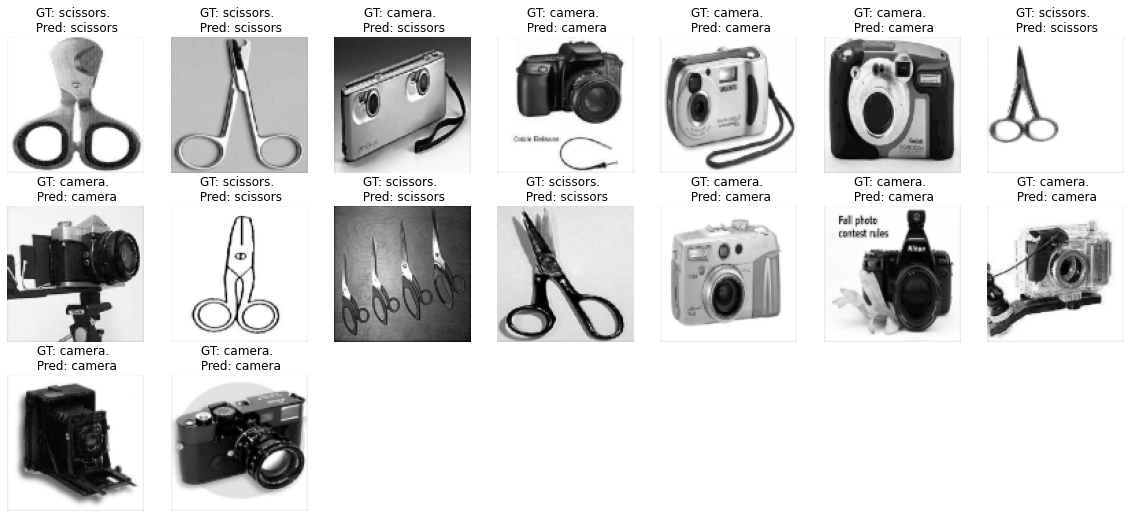

In [8]:
# Show some results
width=20
height=15
plt.rcParams['figure.figsize'] = [width, height]
fig=plt.figure()
imCounter = 1
for i in range(len(Y_test)):
    image=np.reshape(X_test[i,:], (imHeight,imWidth)) 

    plt.subplot(5,7,imCounter)
    plt.imshow(image,cmap='gray')
    plt.axis('off')
    gtLabel = labelNames[Y_test.ravel()[i].astype(int)]
    predLabel = labelNames[Y_pred.ravel()[i].astype(int)]
    plt.title('GT: {}. \n Pred: {}'.format(gtLabel, predLabel))

    imCounter += 1
plt.show()


** g) REPORT:**  Change the kernel and other hyperparameters of your SVC trying to optimize the F1 measure for different cases. Describe in your report the different variants of the model tried. You may want to split your dataset into train, validation and test sets this time to find the best hyperparameters. Present and discuss your findings for different hyperparameters, number of classes and numbers of images. THIS IS THE MOST IMPORTANT PART FOR THE EVALUATION. 

In [15]:
#build DATASET from K categories and (up to) N images from category
K = 2
N = 500
imWidth = 100
imHeight = 100

#selection of label indices
X = np.zeros([K*N,imHeight*imWidth]) #data matrix, one image per row
#Y = np.zeros([K*N,1]) #label indices
Y = -np.ones([K*N,1]) #label indices
labelNames = []


globalCount = 0
for i in range(K): 
    while True:
        lab = random.randint(0,len(labelNamesAll)-1)
        if lab not in labelNames:
            break
    #folders are named after the class label
    filedir = os.path.join(IMDIR,labelNamesAll[lab])
    print(filedir)

    #save the name of the class
    labelNames.append(labelNamesAll[lab])       

    classCount = 0
    for filename in os.listdir(filedir):
        f = os.path.join(filedir, filename)
        if f.endswith(('.jpg')) and (classCount < N):
            image = skimage.io.imread(f, as_gray=True)
            #image = skimage.io.imread(f, as_gray=True)
            image = skimage.transform.resize(image, [imHeight,imWidth],mode='constant')#,anti_aliasing=True)
            X[globalCount,:] = image.flatten()
            Y[globalCount,:] = i
            globalCount += 1
            classCount += 1

#Remove the unused entries of X and Y
print(globalCount)

X = X[:globalCount,:]
Y = Y[:globalCount,:]


101_ObjectCategories\euphonium
101_ObjectCategories\dragonfly
132


In [16]:
# Split in Train and test set with 85% - 15% rule

Ntrain = np.rint(.85*Y.shape[0]).astype(int)
Ntest = Y.shape[0]-Ntrain
print('Training with', Ntrain , 'training samples and ', Ntest, 'testing samples.')

# Randomize the order of X and Y
X, Y = shuffle(X, Y, random_state=0)


# Split the data and labels into training/testing sets
X_train = X[0:Ntrain,:]
Y_train = Y[0:Ntrain,:]

X_test = X[Ntrain:,:]
Y_test = Y[Ntrain:,:]

print("size of train dataset",X_train.shape)
print("size of test dataset",X_test.shape)
print("train target vector",Y_train.T)
print("test target vector",Y_test.T)



Training with 112 training samples and  20 testing samples.
size of train dataset (112, 10000)
size of test dataset (20, 10000)
train target vector [[1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0.
  0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0.
  0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0.
  0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1.]]
test target vector [[0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0.]]


In [17]:
#building a preliminary svm

from sklearn.metrics import plot_confusion_matrix
svm = SVC()
svm.fit(X_train,Y_train)

C:\Users\Meryam\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


SVC()

[1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0.]
macro-f1:  0.7619047619047619
micro-f1:  0.8000000000000002
              precision    recall  f1-score   support

   euphonium       1.00      0.50      0.67         8
   dragonfly       0.75      1.00      0.86        12

    accuracy                           0.80        20
   macro avg       0.88      0.75      0.76        20
weighted avg       0.85      0.80      0.78        20



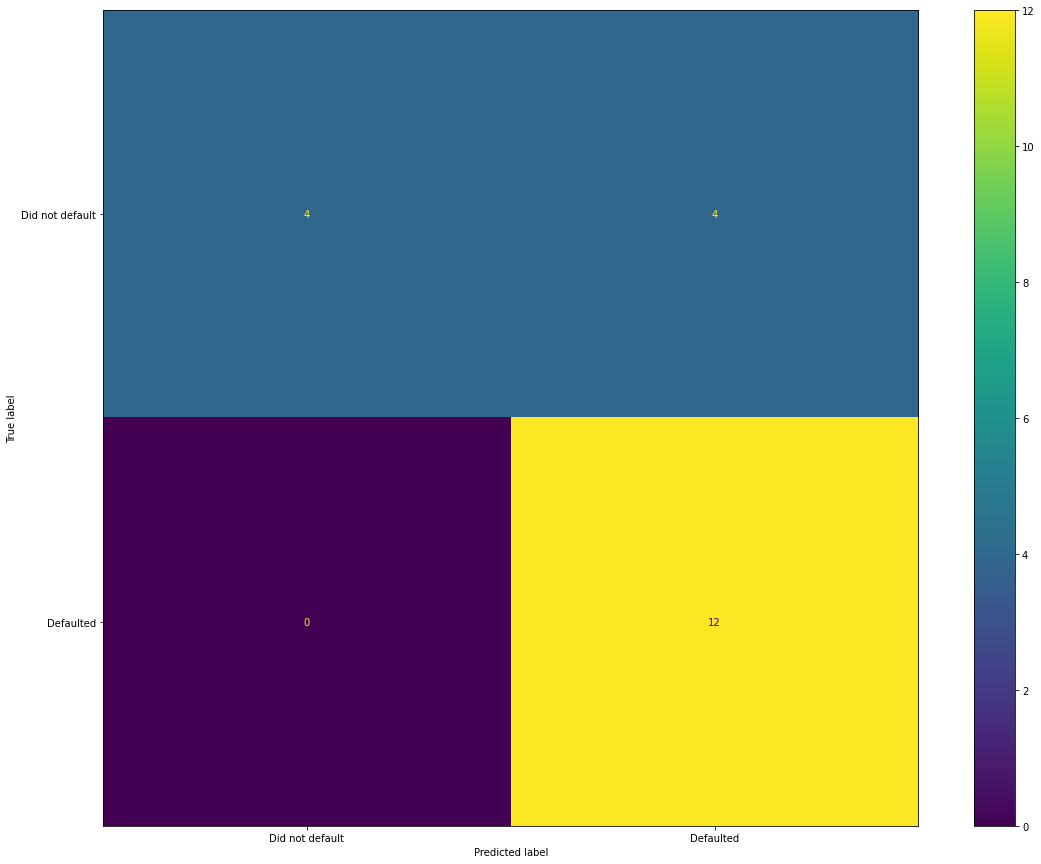

In [18]:
#displaying the confusion matrix
from sklearn.metrics import f1_score

y_pred=svm.predict(X_test)
print(y_pred)
plot_confusion_matrix(svm, X_test, Y_test,values_format='d',display_labels=["Did not default","Defaulted"])
print( "macro-f1: ", f1_score(Y_test, y_pred, average='macro'))
print( "micro-f1: ", f1_score(Y_test, y_pred, average='micro'))
print(classification_report(Y_test.ravel(), y_pred, target_names=labelNames))

In [22]:

# optimizing the parameters

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import GridSearchCV

param_grid = [ {'C' : [0.1 , 1 , 10 , 100 , 1000] , 'gamma' : [1, 0.1, 0.01 , 0.001 , 0.0001], 'kernel' : ['linear', 'poly', 'rbf', 'sigmoid']} , ]

optimal_params= GridSearchCV(svm, param_grid, scoring='accuracy' , refit=True,verbose=3)

optimal_params.fit(X_train,Y_train)
print(optimal_params.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END ..................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV 2/5] END ..................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV 3/5] END ..................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV 4/5] END ..................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV 5/5] END ..................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV 1/5] END ....................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV 2/5] END ....................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV 3/5] END ....................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV 4/5] END ....................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV 5/5] END ....................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV 1/5] END .....................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV 2/5] END .....................C=0.1, gamma

In [20]:
print(optimal_params.best_estimator_)

SVC(C=100, gamma=0.0001)


[1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0.]
macro-f1:  0.8901098901098901
micro-f1:  0.9
              precision    recall  f1-score   support

   euphonium       1.00      0.75      0.86         8
   dragonfly       0.86      1.00      0.92        12

    accuracy                           0.90        20
   macro avg       0.93      0.88      0.89        20
weighted avg       0.91      0.90      0.90        20



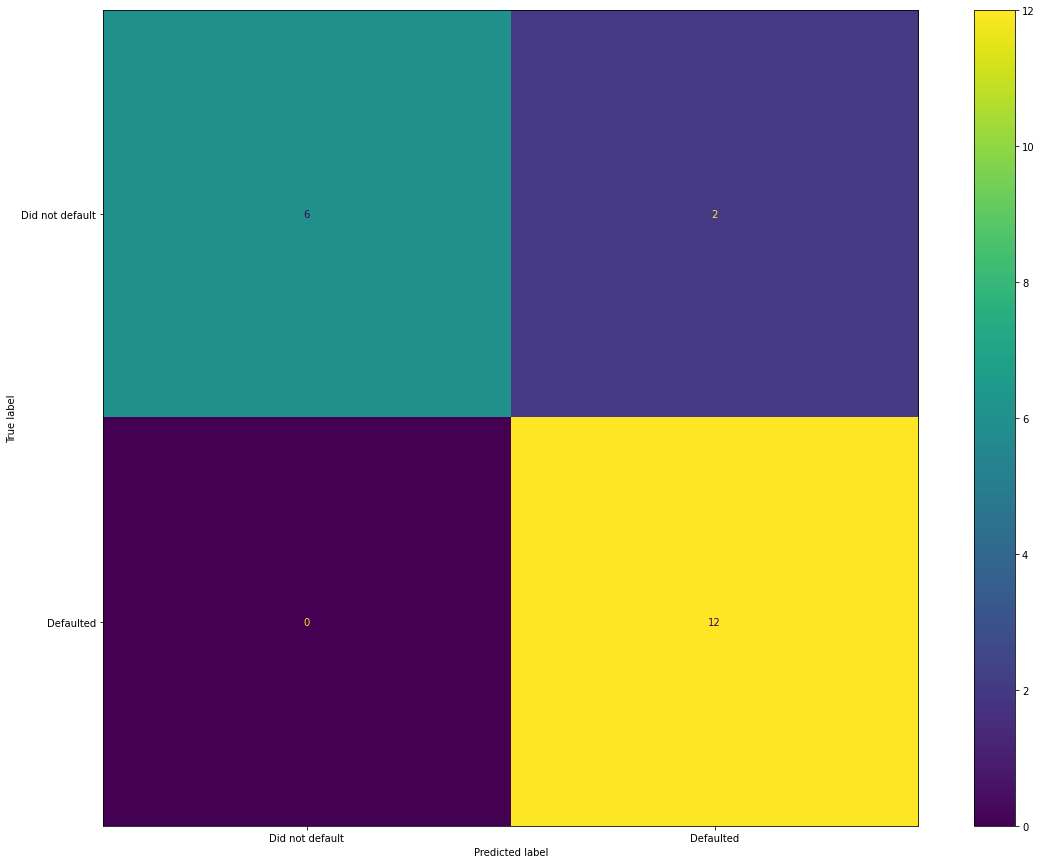

In [21]:
#testing the optimized model

Y_pred=optimal_params.predict(X_test)
print(Y_pred)
plot_confusion_matrix(optimal_params, X_test, Y_test,values_format='d',display_labels=["Did not default","Defaulted"])
print( "macro-f1: ", f1_score(Y_test, Y_pred, average='macro'))
print( "micro-f1: ", f1_score(Y_test, Y_pred, average='micro'))
print(classification_report(Y_test.ravel(), Y_pred, target_names=labelNames))
